# Data ingestion notebook

This notebook includes scripts to download point-of-interest data from various sources. It can be ran manually and piece-by-piece to refresh the data sources as necessary.

In addition to point-of-interest data, we also require road network data and census datasets.

## Data sought

We want a range of different data sources representing different locations of interest. Pulling these from the Google Places API is expensive, so we'll use free sources where possible.

We want to obtain the locations of the following:

- Cafes
- Restaurants
- Bars/Pubs
- Grocery stores
- Pharmacies
- Child care
- Aged care
- Hospitals
- Schools and universities
- Libraries
- Museums
- Galleries
- Parks
- Post offices
- Places of worship

We also want to combine this with census data at the LGA, POA, and suburb levels.

## Area of interest

We are focused on the general Melbourne urban area, represented by these LGAs:

- Banyule
- Bayside (Vic.)
- Boroondara
- Brimbank
- Darebin
- Glen Eira
- Greater Dandenong
- Hobsons Bay
- Hume
- Kingston (Vic.)
- Knox
- Manningham
- Maribyrnong
- Maroondah
- Melbourne
- Melton
- Monash
- Moonee Valley
- Moreland
- Nillumbik
- Port Phillip
- Stonnington
- Whitehorse
- Whittlesea
- Wyndham
- Yarra

This correlates roughly to a bounding box of:

```
N: -37.4
S: -38.1
E: 145.4
W: 144.4
```

We will also report on postcodes and suburbs, but only those that fall completely within the above LGAs.

In overlaying datasources we preference the GDA2020 projection over WGS84, but will convert as necessary.


## Data sources

### Vicmap Features - Features of Interest (FOI) Point

[Link](https://datashare.maps.vic.gov.au/search?md=019d7631-1234-5112-9f21-8f7346647b61)

Coverage:

- Places of worship
- Child care
- Aged care
- Hospitals
- Schools and universities
- Libraries
- Museums
- Galleries
- Parks

Free, provided as shapefile download. 

### Here Geocoding and Search API (`browse` endpoint)

[Link](https://www.here.com/docs/bundle/geocoding-and-search-api-v7-api-reference/page/index.html#/paths/~1browse/get)

Coverage:
- Cafes
- Restaurants
- Bars/Pubs
- Grocery Stores

Paid after 5,000 requests per month. REST API.

### Pharmacy Guild (extra stretch goal)

[Link](https://www.findapharmacy.com.au/)

The Find a Pharmacy website queries an unsecured API backend to populate its map, which we can intercept for our own purposes.

Coverage:
- Pharmacies

Free

### Census 2021 datapacks

[Link](https://www.abs.gov.au/census/find-census-data/datapacks)

Provides direct data for given geographies in CSV. 

### Census geographies

[Link](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files)

Shapefiles for 2021 geographies (in GDA2020). We'll want the population counts as a minimum, but may also have a use for household composition, renter status, and commute data.

### Open Street Maps road geographies

Downloaded via the `osmnx` package.

## Credentials
Refer to the `env.template` file and save as `.env` with credentials attached.

## Processing aims

Location data should be combined into a unified labelling schema in GDA2020, importable to a single geopandas geodataframe with point geometries. Labelling should indicate source and location type, i.e. each location should have:

- GDA2020 point geometry
- Name
- Category
- Source

Data is saved in `data/prepared/` as feather for downstream processing.



## Imports and set up

In [64]:
import os
import geopandas as gpd
from shapely.geometry import Polygon
from dotenv import load_dotenv
from shapely.geometry import box
import numpy as np
import json
import pandas as pd
import requests
from src.utils import create_point_geometry
import time
import osmnx as ox
from pyproj import Transformer



# get credentials and initial settings from env file

load_dotenv()
here_key = os.getenv('HERE_API_KEY')

# area of interest
n,s,e,w = os.getenv('BB_N'), os.getenv('BB_S'), os.getenv('BB_E'), os.getenv('BB_W')

print(n,s,e,w)

bbox_polygon = Polygon([(w, n), (e, n), (e, s), (w, s), (w, n)])
bb_gdf = gpd.GeoDataFrame(index=[0], geometry=[bbox_polygon], crs="EPSG:7844") # GDA2020's EPSG code is 7844

-37.4 -38.1 145.4 144.4


## Shapefile processing

Shapefiles downloaded from the ABS can be quite heavy, we'll pare them down before saving them for further use. We download the files from [here](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files) and put them in the `data/shapefiles/` directory.

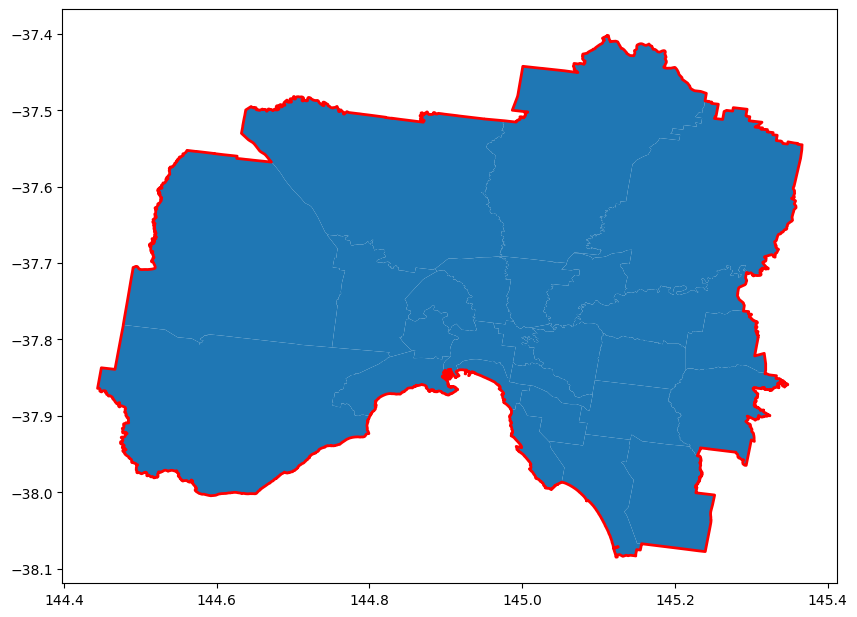

In [52]:
def read_shp(geography, year = 2021):
    filestr =f'data/shapefiles/{geography}_{year}_AUST_GDA2020_SHP/{geography}_{year}_AUST_GDA2020.shp'
    return gpd.read_file(filestr)

lga_shp = read_shp('LGA')
poa_shp = read_shp('POA')
sal_shp = read_shp('SAL')
sa1_shp = read_shp('SA1')


# by trimming the LGA files within the bounding box, we get a more refined area of interest 
lga_gdf = lga_shp[lga_shp.geometry.within(bb_gdf.geometry[0])]

lga_area_of_interest = lga_gdf.unary_union

def add_AoI_to_plot(ax):
    gpd.GeoSeries([lga_area_of_interest]).plot(ax=ax, color='none', edgecolor='red', linewidth=2)

add_AoI_to_plot(lga_gdf.plot(figsize=(10, 10)))

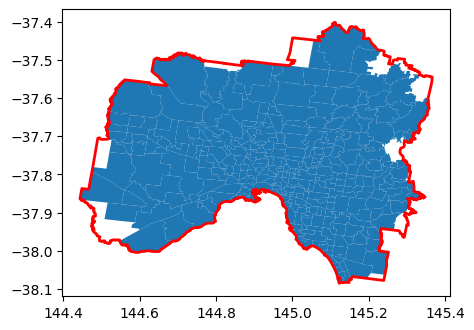

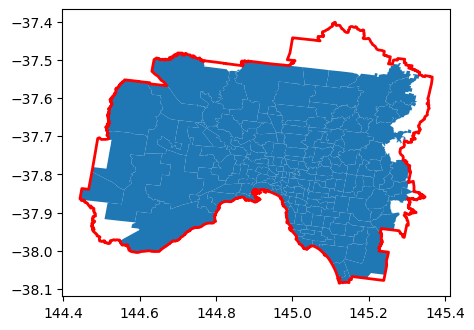

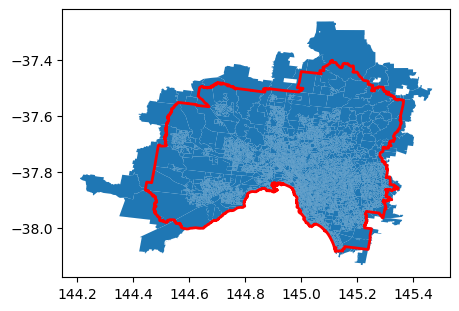

In [57]:
# For POA and SAL geographies, we're happy to take the intersection

sal_gdf = sal_shp[sal_shp.geometry.within(lga_area_of_interest)]
poa_gdf = poa_shp[poa_shp.geometry.within(lga_area_of_interest)]
sa1_gdf = sa1_shp[sa1_shp.geometry.intersects(lga_area_of_interest)]

add_AoI_to_plot(sal_gdf.plot(figsize=(5, 5)))
add_AoI_to_plot(poa_gdf.plot(figsize=(5, 5)))
add_AoI_to_plot(sa1_gdf.plot(figsize=(5, 5)))

There are 1854 cells in total with a 1500m resolution


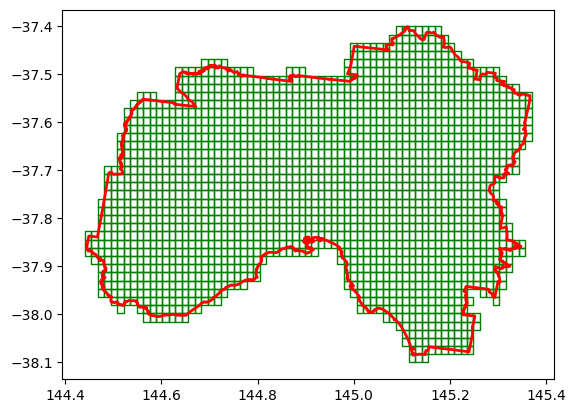

In [58]:

# For some APIs we'll want to do grid-based querying

def km_to_deg(km, lat):
    km_per_degree_latitude = 111.32
    km_per_degree_longitude = 111.32 * np.cos(np.radians(lat))
    return km / km_per_degree_latitude, km / km_per_degree_longitude

def generate_tiled_gdf(bounding_box, resolution, crs="EPSG:7844"):
    minx, miny, maxx, maxy = bounding_box.bounds
    width_deg, height_deg = km_to_deg(resolution, (miny + maxy) / 2)
    
    rows = int(np.ceil((maxy - miny) / height_deg))
    cols = int(np.ceil((maxx - minx) / width_deg))
    
    squares = []
    for i in range(rows):
        for j in range(cols):
            bot_left_lat = miny + i * height_deg
            bot_left_lon = minx + j * width_deg
            square = box(bot_left_lon, bot_left_lat, 
                         bot_left_lon + width_deg, bot_left_lat + height_deg)
            squares.append(square)
    
    return gpd.GeoDataFrame(geometry=squares, crs=crs)

##### TWEAK THIS TO INFLUENCE THE NUMBER OF CELLS (AND THEREFORE API CALLS)
resolution_m = 1500
#####

grid_gdf = generate_tiled_gdf(bb_gdf.unary_union, resolution_m/1000)
grid_samples_gdf = grid_gdf[grid_gdf.geometry.intersects(lga_area_of_interest)] # filter it down


add_AoI_to_plot(grid_samples_gdf.plot(color='none', edgecolor='green', linewidth=1))

print(f'There are {len(grid_samples_gdf)} cells in total with a {resolution_m}m resolution')

834


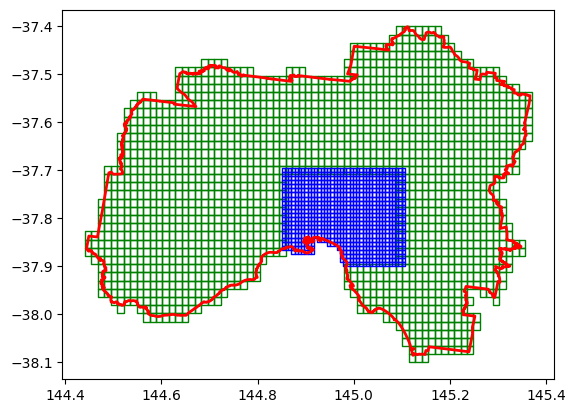

In [59]:
# we'll also want to sample the inner city more finely:

fine_resolution = 750
fine_bb = {
    'n': -37.7, 
    's': -37.9,
    'e': 145.1,
    'w': 144.85
}

fine_bb_poly = Polygon([
    (fine_bb['w'], fine_bb['n']), 
    (fine_bb['e'], fine_bb['n']), 
    (fine_bb['e'], fine_bb['s']), 
    (fine_bb['w'], fine_bb['s']), 
    (fine_bb['w'], fine_bb['n'])
])

fine_grid_gdf = generate_tiled_gdf(fine_bb_poly, fine_resolution/1000)
fine_grid_gdf = fine_grid_gdf[fine_grid_gdf.intersects(lga_area_of_interest)]
coarse_grid_gdf = grid_samples_gdf[~grid_samples_gdf.within(fine_bb_poly)]


ax = coarse_grid_gdf.plot(color='none', edgecolor='green', linewidth=1)
fine_grid_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)
add_AoI_to_plot(ax)

print(len(fine_grid_gdf))

grid_samples_gdf = pd.concat([coarse_grid_gdf,fine_grid_gdf])

## Vicmap processing

Export and download the latest shapefile for the above co-ordinates in the GDA2020 projection. Use the area of interest bounding box shapefiles to filter down the export required. Copy the contents of `user_polygon-0` to the `data` folder as `vicmap-foi`.

In [135]:
vicmap_gdf = gpd.read_file('data/vicmap-foi/VMFEAT/FOI_POINT.shp')

# processing:
# - filter desired fields
# - map to desired columns (multipoint -> point geometries)

vicmap_labels = [
    'child care','aged care','entertainment centre','hall','community centre','senior citizens','art gallery','museum','library',
    'primary/secondary school','special school','primary school','tertiary institution','secondary school','university',
    'police station','ambulance station','fire station','maternal/child health centre','general hospital','day procedure centre',
    'tower','monument','tourist attraction','church','mosque','synagogue','rotunda','day visitor area','club house',
    'picnic site','playground','swimming pool'
]

cleaned_vicmap_gdf = (
    vicmap_gdf
    [vicmap_gdf['FEATSUBTYP'].isin(vicmap_labels)]
    [['FEATSUBTYP','NAME_LABEL','geometry']]
    .rename(columns = {'FEATSUBTYP': 'category', 'NAME_LABEL': 'name'})
)

def convert_multi_to_pt(geom):
    return geom.geoms[0] if geom.geom_type == 'MultiPoint' else geom

cleaned_vicmap_gdf['geometry'] = cleaned_vicmap_gdf['geometry'].apply(convert_multi_to_pt)

cleaned_vicmap_gdf['source'] = 'vicmap_foi'

cleaned_vicmap_gdf.to_feather('data/prepared/vicmap.feather')

cleaned_vicmap_gdf.head(5)


,category,name,geometry,source
0,secondary school,Elisabeth Murdoch College,POINT (145.19019 -38.15928),vicmap_foi
1,primary school,Frankston Heights Primary School,POINT (145.14718 -38.16179),vicmap_foi
2,secondary school,Koo Wee Rup Secondary College,POINT (145.49578 -38.19708),vicmap_foi
3,primary school,St Augustines School,POINT (145.14588 -38.17203),vicmap_foi
4,special school,Mount Erin Secondary College - Mount Erin Deaf...,POINT (145.14623 -38.17396),vicmap_foi


In [136]:
# location counts
cleaned_vicmap_gdf[['category','geometry']].groupby('category').count()

,geometry
category,
aged care,512
ambulance station,97
art gallery,31
child care,3523
church,602
club house,448
community centre,228
day procedure centre,95
day visitor area,64


## Here API processing

The Browse endpoints returns locations matching a category, within a specified area. We want these place categories:

- `100-1100` Coffee/Tea
- `100-1000` Dining
- `200-2000-0011` Bar/Pub
- `600-6300-0066` Grocery Store

In [137]:
def get_data_from_api(base_url, params, save_file=False, dry=False):
    unwrapped_params = {
        key: ','.join(map(str, value)) if isinstance(value, list) else value
        for key, value in params.items()
    }

    if dry:
        req = requests.Request('GET', base_url, params=unwrapped_params)
        prepared_req = req.prepare()
        return prepared_req.url

    response = requests.get(base_url, params=unwrapped_params)
    
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
    data = response.json()

    if save_file:
        with open(save_file, 'w') as file:
            json.dump(data, file)


    return data

In [143]:
# run this cell only once to be able to start/stop the cell that actually queries the API
# while keeping track of what has been downloaded already
here_categories = ['100-1100','100-1000','200-2000-0011','600-6300-0066']
responses = []
empty_cell_index = []
downloaded_cell_index = []

In [147]:
print(empty_cell_index)
print(downloaded_cell_index)

[19, 29, 31, 32, 56, 73, 74, 75, 102, 117, 118, 121, 123, 141, 144, 150, 152, 153, 154, 155, 161, 176, 179]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 33, 34, 35, 36, 37, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 119, 120, 122, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 145, 146, 147, 148, 149, 151, 156, 157, 158, 159, 160, 169, 170, 171, 172, 173, 174, 175, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188]


In [145]:
# delete this
import time
grid_samples_gdf = fine_grid_gdf

In [148]:
counter = 0

for index, row in grid_samples_gdf.iterrows():

    if(index in empty_cell_index): continue
    if(index in downloaded_cell_index): continue

    centroid = row['geometry'].centroid
    minx, miny, maxx, maxy = row['geometry'].bounds

    params = {
        'apiKey': here_key,
        'categories': here_categories,
        'at':[centroid.y,centroid.x],
        'in':f"bbox:{minx},{miny},{maxx},{maxy}",
        'limit':100    
    }

    # print(get_data_from_api('https://browse.search.hereapi.com/v1/browse',params, dry=True))

    fname = f'data/rawjson/cell_{index}.json'

    # this calls the api and saves the json directly if desired
    response = get_data_from_api('https://browse.search.hereapi.com/v1/browse',params, save_file=fname)

    if len(response['items'])>0:
        responses.append(response)
        counter = counter+1
        downloaded_cell_index.append(index)
        print(f'Found data in cell {index} of {len(grid_samples_gdf)}, downloaded this run: {counter}')
    else:
        empty_cell_index.append(index)

    time.sleep(.5)

    # if counter>100: break # uncomment to test with smaller samples

Found data in cell 189 of 834, downloaded this run: 1
Found data in cell 191 of 834, downloaded this run: 2
Found data in cell 193 of 834, downloaded this run: 3
Found data in cell 194 of 834, downloaded this run: 4
Found data in cell 195 of 834, downloaded this run: 5
Found data in cell 196 of 834, downloaded this run: 6
Found data in cell 197 of 834, downloaded this run: 7
Found data in cell 204 of 834, downloaded this run: 8
Found data in cell 205 of 834, downloaded this run: 9
Found data in cell 206 of 834, downloaded this run: 10
Found data in cell 207 of 834, downloaded this run: 11
Found data in cell 208 of 834, downloaded this run: 12
Found data in cell 209 of 834, downloaded this run: 13
Found data in cell 210 of 834, downloaded this run: 14
Found data in cell 211 of 834, downloaded this run: 15
Found data in cell 212 of 834, downloaded this run: 16
Found data in cell 213 of 834, downloaded this run: 17
Found data in cell 214 of 834, downloaded this run: 18
Found data in cell 

In [45]:
# if necessary to load all the json back in

# import glob
# import json
# json_path = 'data/rawjson/*.json'
# responses = []

# for file_path in glob.glob(json_path):
#     with open(file_path, 'r') as file:
#         data = json.load(file)
#         responses.append(data)

In [151]:
here_dfs = []

def HEREAPI_data_to_df(data):

    records = []
    for x in data['items']:
        id = x.get('id')
        name = x.get('title')
        position = {'lat': x['position']['lat'], 'lng': x['position']['lng']}
        access = {'lat': x['access'][0]['lat'], 'lng': x['access'][0]['lng']}
        categories = [category['name'] for category in x.get('categories', [])]

        # Append the extracted data as a dictionary to the records list
        records.append({
            'id': id,
            'name': name,
            'position': position,
            'access': access,
            'categories': categories,
            'primary_category': categories[0]
        })

    here_df = pd.DataFrame(records)
    here_df['n_categories'] = here_df['categories'].apply(lambda x: len(x))
    here_df['coords_for_point'] = np.where(here_df['access'].notnull(), here_df['access'], here_df['position'])
    here_df['coffee'] = here_df['categories'].apply(lambda x: any('coffee' in str(item).lower() for item in x))
    return here_df

for i in responses:
    if len(i['items'])==0: continue
    here_dfs.append(HEREAPI_data_to_df(i))

here_df = pd.concat(here_dfs).reset_index(drop=True)

here_df['geometry']=here_df['coords_for_point'].apply(create_point_geometry)
here_df['source']='here_api'
here_df['category']=here_df['primary_category'].str.lower()



In [152]:
# create gdf with projection in WGS84
here_gdf = gpd.GeoDataFrame(here_df[['name','category','coffee','source','geometry']], geometry='geometry')
here_gdf.crs = 'EPSG:4326'
here_gdf.to_crs('EPSG:7844',inplace=True) # convert to GDA20
here_gdf = here_gdf[here_gdf.within(lga_area_of_interest)] # trim ones outside the area of interest
here_gdf = here_gdf.drop_duplicates().reset_index(drop=True) # we have some overlapping cells
here_gdf.sample(10)

#CHECKPOINT
here_gdf.to_feather('data/prepared/checkpoint.feather')

,name,category,coffee,source,geometry
2198,Bugiardo,restaurant,False,here_api,POINT (145.06337 -37.84673)
7225,Bamboo Vietnamese Restaurant,restaurant,False,here_api,POINT (144.99676 -37.78057)
6349,Wolf's Lair,bar or pub,False,here_api,POINT (144.96749 -37.79754)
2070,Juicy Dumplings on Chapel,restaurant,True,here_api,POINT (144.99410 -37.84711)
4349,McDonald's,fast food,False,here_api,POINT (144.88391 -37.81286)
7427,Costanzo Puppa,restaurant,False,here_api,POINT (144.91914 -37.76620)
3749,Cafe 34,cafeteria,True,here_api,POINT (144.96216 -37.81808)
4322,Pizza Industry,restaurant,False,here_api,POINT (145.10524 -37.82124)
5778,University Cafe,cafeteria,True,here_api,POINT (144.96714 -37.79951)
7900,Mamma's,restaurant,False,here_api,POINT (144.92626 -37.75929)


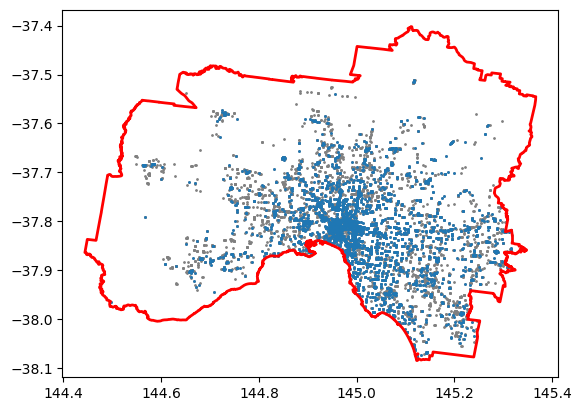

In [171]:
# places that serve coffee, highlighted

ax = here_gdf.plot(markersize=1, color = 'grey')

here_gdf[here_gdf['coffee']].plot(markersize=1, ax=ax)

add_AoI_to_plot(ax)

In [200]:
# we want to create two different datasets -- locations that map to broader categories like cafe, restaurant, and a list of all places you can get coffee

coffee_here_gdf = here_gdf[here_gdf['coffee']].reset_index(drop=True)
coffee_here_gdf['category'] = 'coffee_available'
coffee_here_gdf.drop('coffee', axis=1, inplace=True)

coffee_here_gdf.to_feather('data/prepared/coffee.feather')

coffee_here_gdf.sample(20)

,name,category,source,geometry
4722,The Daily Life Cafe,coffee_available,here_api,POINT (145.21784 -37.85457)
4771,XS Roasting Kitchen,coffee_available,here_api,POINT (145.15907 -37.90926)
4367,Siesta Cafe,coffee_available,here_api,POINT (145.08708 -38.00775)
1261,Kenny's Bakery Cafe,coffee_available,here_api,POINT (144.96147 -37.82096)
323,Crowded House,coffee_available,here_api,POINT (144.89926 -37.85902)
4194,Eating House,coffee_available,here_api,POINT (145.25299 -37.92747)
1893,Donnini's,coffee_available,here_api,POINT (144.96714 -37.79951)
3341,Middleborough Latte Cafe,coffee_available,here_api,POINT (145.14050 -37.80823)
3404,Truckies Drive in Cafe,coffee_available,here_api,POINT (144.81464 -37.81592)
712,Hibiki,coffee_available,here_api,POINT (145.07776 -37.84833)


In [202]:

desired_categories = [
    'restaurant', 'grocery', 'cafeteria', 'fast food', 'coffee shop', 'bar or pub', 'bakery & baked goods store',
    'casual dining', 'hotel', 'nightlife-entertainment', 'food/beverage specialty store', 'tea house',
    'convenience store', 'sports facility/venue', 'coffee/tea', 'market', 'sweet shop', 'food market/stall',
    'wine & liquor', 'deli', 'brewery', 'winery', 'butcher', 'specialty food store'
    ]

places_here_gdf = here_gdf[here_gdf['category'].isin(desired_categories)].drop('coffee', axis=1)

places_gdf = pd.concat([places_here_gdf,cleaned_vicmap_gdf]).reset_index(drop=True)

# map places to some primary categories

def category_mapping(category:str):
    category = category.lower()
    remap = {
        'aged care':'aged care',
        'senior citizens':'aged care',
        'art gallery':'art gallery',
        'bar or pub':'bar or pub',
        'nightlife-entertainment':'bar or pub',
        'sports facility/venue':'bar or pub',
        'brewery':'bar or pub',
        'winery':'bar or pub',
        'coffee shop':'cafe',
        'tea house':'cafe',
        'coffee/tea':'cafe',
        'child care':'child care',
        'hall':'community area',
        'club house':'community area',
        'community centre':'community area',
        'ambulance station':'emergency services',
        'fire station':'emergency services',
        'police station':'emergency services',
        'entertainment centre':'entertainment centre',
        'bakery & baked goods store':'grocery or supermarket',
        'grocery':'grocery or supermarket',
        'convenience store':'grocery or supermarket',
        'sweet shop':'grocery or supermarket',
        'food/beverage specialty store':'grocery or supermarket',
        'wine & liquor':'grocery or supermarket',
        'specialty food store':'grocery or supermarket',
        'deli':'grocery or supermarket',
        'food market/stall':'grocery or supermarket',
        'butcher':'grocery or supermarket',
        'market':'grocery or supermarket',
        'library':'library',
        'maternal/child health centre':'medical facility',
        'general hospital':'medical facility',
        'day procedure centre':'medical facility',
        'museum':'museum',
        'rotunda':'park area',
        'playground':'park area',
        'picnic site':'park area',
        'day visitor area':'park area',
        'church':'place of worship',
        'mosque':'place of worship',
        'synagogue':'place of worship',
        'cafeteria':'restaurant',
        'restaurant':'restaurant',
        'fast food':'restaurant',
        'casual dining':'restaurant',
        'hotel':'restaurant',
        'secondary school':'school',
        'primary school':'school',
        'special school':'school',
        'primary/secondary school':'school',
        'swimming pool':'swimming pool',
        'university':'tertiary institution',
        'tertiary institution':'tertiary institution',
        'monument':'tourist attraction',
        'tower':'tourist attraction',
        'tourist attraction':'tourist attraction'
    }
    remapped_cat = remap[category]
    return remapped_cat

places_gdf['child_category'] = places_gdf['category']
places_gdf['category'] = places_gdf['child_category'].apply(category_mapping)

places_gdf.to_feather('data/prepared/places.feather')

places_gdf.sample(20)

,name,category,source,geometry,child_category
20182,Seda College (Victoria) - Cross Keys Reserve C...,school,vicmap_foi,POINT (144.92876 -37.74370),secondary school
16820,Hot Shot Cafe,restaurant,here_api,POINT (144.89828 -37.80409),cafeteria
17,Martin Street Chargrill Chicken,restaurant,here_api,POINT (145.00463 -37.89747),restaurant
16918,Estia Health Dandenong,aged care,vicmap_foi,POINT (145.22427 -37.97777),aged care
24518,Plenty Parklands Primary School,school,vicmap_foi,POINT (145.07695 -37.66971),primary school
27696,None,park area,vicmap_foi,POINT (145.24782 -37.85031),playground
1003,Lion Dance Restaurant,restaurant,here_api,POINT (144.90129 -37.85936),restaurant
13973,China Bar Doncaster Road,restaurant,here_api,POINT (145.11983 -37.78819),restaurant
4301,Kindred Studios,bar or pub,here_api,POINT (144.90058 -37.81192),bar or pub
10603,Crusty Pizza & Burgers,restaurant,here_api,POINT (145.20116 -37.98261),restaurant


## Census processing

Place the csvs from the datapack downloads for the latest (2021) census in the `/data/census/` folder, for each geography (LGA,POA,SAL). Data packs are available [here](https://www.abs.gov.au/census/find-census-data/datapacks). We attach these to the shapefile geodataframes above before saving them. We are interested in data from G01, G02, G34, G36, G37.

In [60]:
statistics_of_interest = {
    'link_key':'link_key',
    'Tot_P_P': 'population',
    'Median_age_persons': 'median_age',
    'Median_mortgage_repay_monthly': 'median_mortgage_repayment_monthly',
    'Median_rent_weekly': 'median_rent_weekly',
    'Average_num_psns_per_bedroom': 'average_persons_per_bedroom',
    'Median_tot_hhd_inc_weekly': 'median_household_income_weekly',
    'Average_household_size': 'average_household_size',
    'Num_MVs_per_dweling_0_MVs': 'households_with_0_cars',
    'Num_MVs_per_dweling_1_MVs': 'households_with_1_cars',
    'Num_MVs_per_dweling_2_MVs': 'households_with_2_cars',
    'Num_MVs_per_dweling_3_MVs': 'households_with_3_cars',
    'Num_MVs_per_dweling_4mo_MVs': 'households_with_4mo_cars',
    'Num_MVs_per_dweling_Tot': 'households',
    'OPDs_Separate_house_Dwellings': 'occupied_private_houses',
    'OPDs_SD_r_t_h_th_Tot_Dwgs': 'occupied_private_townhouses',
    'OPDs_Flt_apart_Tot_Dwgs': 'occupied_private_apartments',
    'Unoccupied_PDs_Dwgs': 'unoccupied_private_dwellings',
    'OPDs_Tot_OPDs_Dwellings': 'occupied_private_dwellings',
    'Total_PDs_Dwellings': 'private_dwellings',
    'O_OR_Total': 'dwelling_owned_outright',
    'O_MTG_Total': 'dwelling_owned_mortgage',
    'R_RE_Agt_Total': 'dwelling_rented_realestate',
    'R_ST_h_auth_Total': 'dwelling_state_housing',
    'R_Com_Hp_Total': 'dwelling_community_housing',
    'R_Tot_Total': 'dwelling_rented'
}

codes = ['G01', 'G02', 'G34', 'G36', 'G37']

def read_census(geography, code, year):
    df = pd.read_csv(f'data/census/{year}Census_{code}_VIC_{geography}.csv')
    df['link_key'] = df[f'{geography}_CODE_{year}'].astype(str).str.replace('[a-zA-Z]', '', regex=True)
    df = df[[column for column in df.columns if column in statistics_of_interest.keys()]]
    df.rename(columns=statistics_of_interest, inplace=True)
    df['geography'] = geography
    return df

def process_census(df):
    # any transforms here
    df['pct_dwellings_unoccupied'] = df['unoccupied_private_dwellings'] / df['private_dwellings']
    df['pct_households_wo_cars'] = df['households_with_0_cars'] / df['households']
    df['pct_renters'] = df['dwelling_rented'] / df['occupied_private_dwellings']
    df['pct_owner_occupiers'] = (df['dwelling_owned_outright'] + df['dwelling_owned_mortgage']) / df['occupied_private_dwellings']
    df['pct_apartments'] = df['occupied_private_apartments'] / df['occupied_private_dwellings']
    df['pct_houses'] = df['occupied_private_houses'] / df['occupied_private_dwellings']
    df['pct_townhouses'] = df['occupied_private_townhouses'] / df['occupied_private_dwellings']
    return df

def collect_census(geography, year=2021):
    dfs = []
    for code in codes:
        df = read_census(geography,code,year)
        dfs.append(df)
    
    result_df = dfs[0]

    for df in dfs[1:]:
        result_df = result_df.merge(df, on=['geography', 'link_key'], how='left')

    return process_census(result_df)

def add_link_col(gdf, geography, year_str = '21'):
    geog_name_col = geography+'_NAME'+year_str
    link_name_col = geography + '_CODE' + year_str 
    
    if gdf.get(geog_name_col) is None:
        gdf[geog_name_col] = gdf[link_name_col]

    return gdf.rename(columns={
        link_name_col: 'link_key',
        'AREASQKM21': 'area_sqkm',
        geog_name_col: 'geography_name'
    })[['link_key','area_sqkm','geography_name','geometry']]

def read_and_merge_geography_data(shapefile_gdf,geography:str):
    census_df = collect_census(geography)
    return add_link_col(shapefile_gdf,geography).merge(census_df,on=['link_key'],how='left')


lga_census_gdf = read_and_merge_geography_data(lga_gdf,'LGA')
poa_census_gdf = read_and_merge_geography_data(poa_gdf,'POA')
sal_census_gdf = read_and_merge_geography_data(sal_gdf,'SAL')
sa1_census_gdf = read_and_merge_geography_data(sa1_gdf,'SA1')

lga_census_gdf.to_feather('data/prepared/lga.feather')
poa_census_gdf.to_feather('data/prepared/poa.feather')
sal_census_gdf.to_feather('data/prepared/sal.feather')
sa1_census_gdf.to_feather('data/prepared/sa1.feather')


/opt/homebrew/anaconda3/envs/walkability/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Road network

The road network is read in and saved from the `osmnx` package. We retrieve all paths that can be walked on within the target area, and save as a more lightweight pandana file



In [65]:
walking_graph = ox.graph_from_polygon(lga_area_of_interest, network_type='walk', simplify=False, retain_all=False)
nodes, edges = ox.graph_to_gdfs(walking_graph)

edges = edges.reset_index() # bring u and v into the dataframe


# convert the nodes to GDA20
wgs84_to_gda20 = Transformer.from_crs("EPSG:4326", "EPSG:7844", always_xy=True)
def gda_from_node(node):    
    x, y = wgs84_to_gda20.transform(node['x'], node['y'])
    return x, y
nodes[['x_gda','y_gda']] = nodes.apply(lambda row: gda_from_node(row), axis=1, result_type='expand')

# save the network definition for later analysis
pd.DataFrame({
    'x':nodes['x_gda'],
    'y':nodes['y_gda']
}).to_feather('data/prepared/graph_nodes.feather')

pd.DataFrame({
    'u':edges['u'],
    'v':edges['v'],
    'w':edges['length']
}).to_feather('data/prepared/graph_edges.feather')


<Axes: >

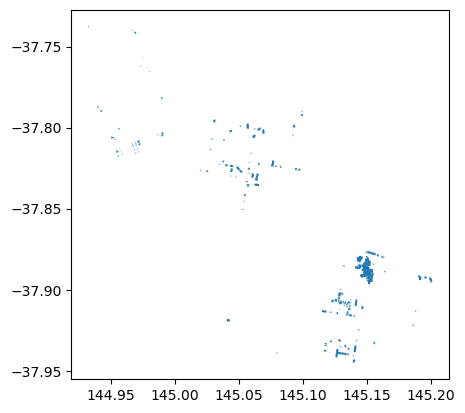

In [50]:
edges.head(1000).plot()

In [51]:
nodes.shape

(1689061, 6)